# Import Modules

In [1]:
from fish_helpers import *
from MERFISH_Objects.FISHData import *
import anndata
import scanpy as sc
from sklearn.preprocessing import normalize
from scipy.stats import pearsonr,spearmanr

# Load Data

In [2]:
""" Measured Data """
data = anndata.read_h5ad('/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/results/clustered.h5ad')

In [3]:
data

AnnData object with n_obs × n_vars = 97786 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'stage_x', 'stage_y', 'leiden', 'opt_types'
    uns: 'leiden', 'neighbors'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors'
    obsp: 'connectivities', 'distances'

In [4]:
""" Reference Data """
ref_data = anndata.read_h5ad('/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/SmartSeq_dpnmf/anndata.h5ad')

In [5]:
ref_data

AnnData object with n_obs × n_vars = 74973 × 24
    obsm: 'Level_1_class_label', 'Level_2_neighborhood_label', 'Level_3_subclass_label', 'Level_4_supertype_label', 'Level_5_cluster_label', 'cell_type_accession_color', 'cell_type_accession_id', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_id', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_id', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_id', 'cell_type_designation_label', 'class_color', 'class_label', 'class_order', 'cluster_color', 'cluster_label', 'cluster_order', 'cortical_layer_label', 'donor_sex_label', 'exp_component_name', 'external_donor_name_color', 'external_donor_name_id', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_id', 'facs_population_plan_label', 'full_genotype_color', 'full_genotype_id', 'full_genotype_label', 'injection_materials_color', 'injection_materials_id', 'injection_materials_label',

# Convert to Angular

In [6]:
data.layers['DPNMF'] = data.layers['total_vectors'].copy()
data.X = data.layers['total_vectors'].copy()
data = data[np.isnan(data.X.max(1))==False]
data.X = data.X/np.array(data.obs['total_signal'])[:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.layers['DPNMF_IQR'] = data.X.copy()
data.X = normalize(data.X)
data.layers['DPNMF_IQR_L2'] = data.X.copy()

In [7]:
ref_data.layers['DPNMF'] = ref_data.X.copy()
ref_data = ref_data[np.isnan(ref_data.X.max(1))==False]
ref_data.X = ref_data.X - np.array([np.percentile(ref_data.X[:,i],25) for i in range(ref_data.X.shape[1])])
ref_data.X = ref_data.X / np.array([np.percentile(ref_data.X[:,i],75) for i in range(ref_data.X.shape[1])])
ref_data.layers['DPNMF_IQR'] = ref_data.X.copy()
ref_data.X = normalize(ref_data.X)
ref_data.layers['DPNMF_IQR_L2'] = ref_data.X.copy()

# Harmonize

In [8]:
temp_data = data[data.layers['DPNMF_IQR'].max(1)!=0]
temp_ref_data = ref_data[ref_data.layers['DPNMF_IQR'].max(1)!=0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [01:14<00:00,  2.79it/s]


<Figure size 1080x1080 with 0 Axes>

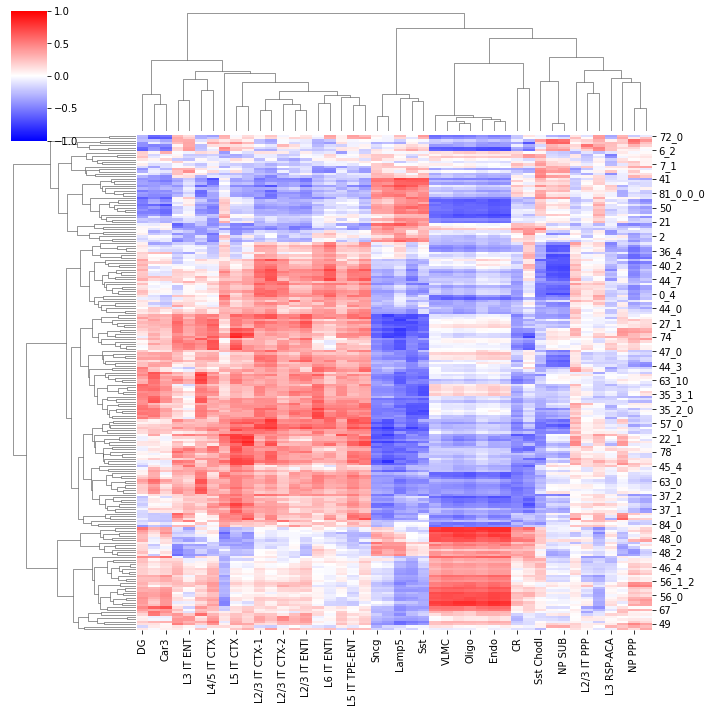

In [13]:
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_3_subclass_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =data_labels==i_label
    I = np.median(temp_data.layers['DPNMF_IQR'][i_mask,:],axis=0)
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        J = np.median(temp_ref_data.layers['DPNMF_IQR'][j_mask,:],axis=0)
        cmat[i,j] = spearmanr(I,J)[0]
# cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='bwr',vmin=-1,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [01:52<00:00,  1.83it/s]
/home/zach/miniconda3/envs/pyfish_3.9/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1080x1080 with 0 Axes>

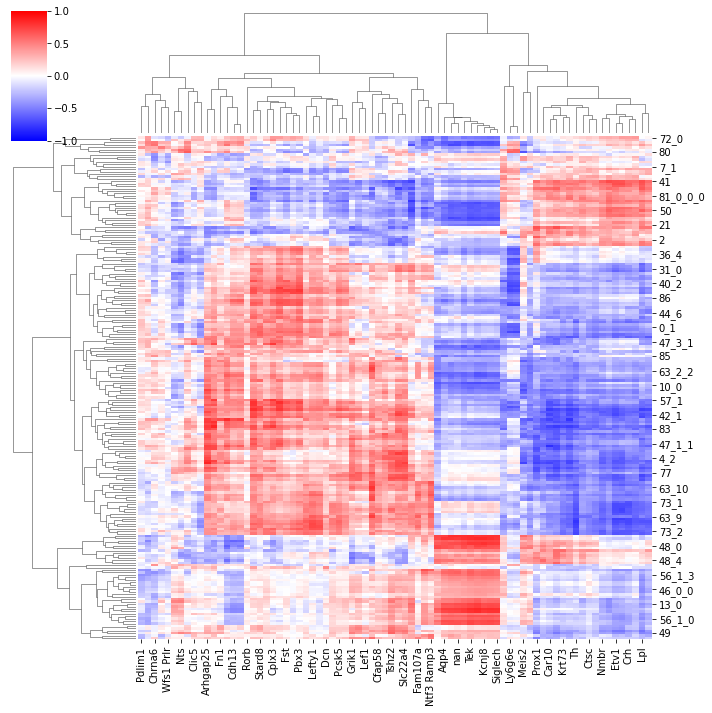

In [14]:
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_4_supertype_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =data_labels==i_label
    I = np.median(temp_data.layers['DPNMF_IQR'][i_mask,:],axis=0)
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        J = np.median(temp_ref_data.layers['DPNMF_IQR'][j_mask,:],axis=0)
        cmat[i,j] = spearmanr(I,J)[0]
# cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='bwr',vmin=-1,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [08:04<00:00,  2.34s/it]


<Figure size 1080x1080 with 0 Axes>

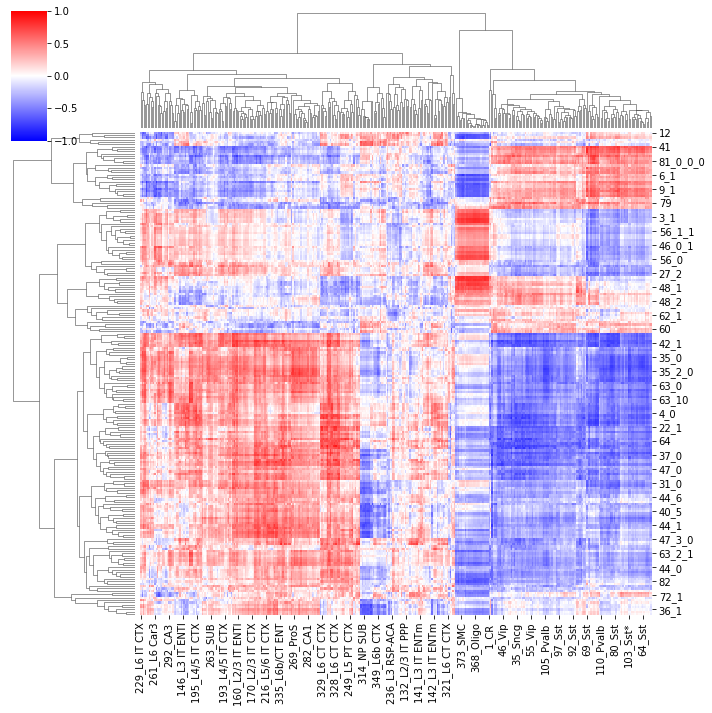

In [15]:
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_5_cluster_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =data_labels==i_label
    I = np.median(temp_data.layers['DPNMF_IQR'][i_mask,:],axis=0)
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        J = np.median(temp_ref_data.layers['DPNMF_IQR'][j_mask,:],axis=0)
        cmat[i,j] = spearmanr(I,J)[0]
# cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='bwr',vmin=-1,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:56<00:00,  3.65it/s]


<Figure size 1080x1080 with 0 Axes>

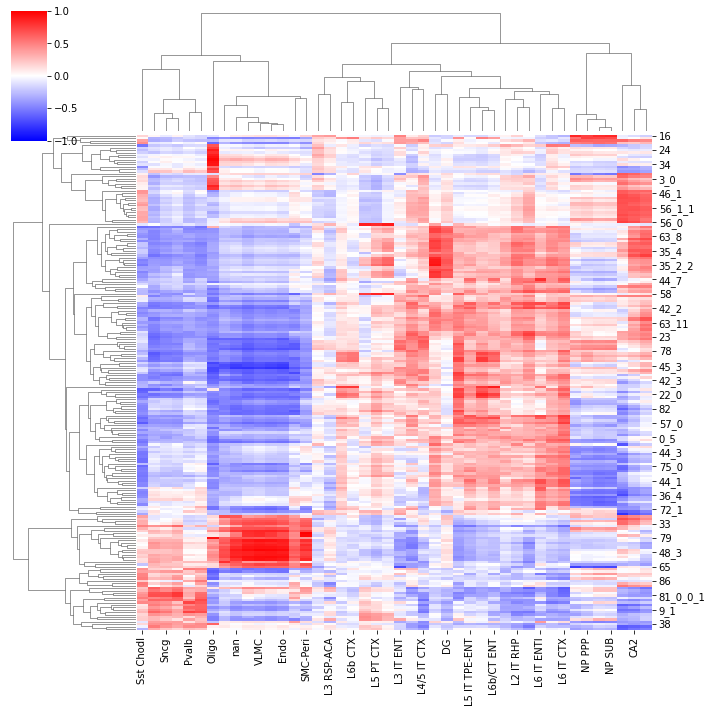

In [16]:
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_3_subclass_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =data_labels==i_label
    I = np.median(temp_data.layers['DPNMF_IQR'][i_mask,:],axis=0)
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        J = np.median(temp_ref_data.layers['DPNMF_IQR'][j_mask,:],axis=0)
        cmat[i,j] = pearsonr(I,J)[0]
# cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='bwr',vmin=-1,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [01:34<00:00,  2.20it/s]


<Figure size 1080x1080 with 0 Axes>

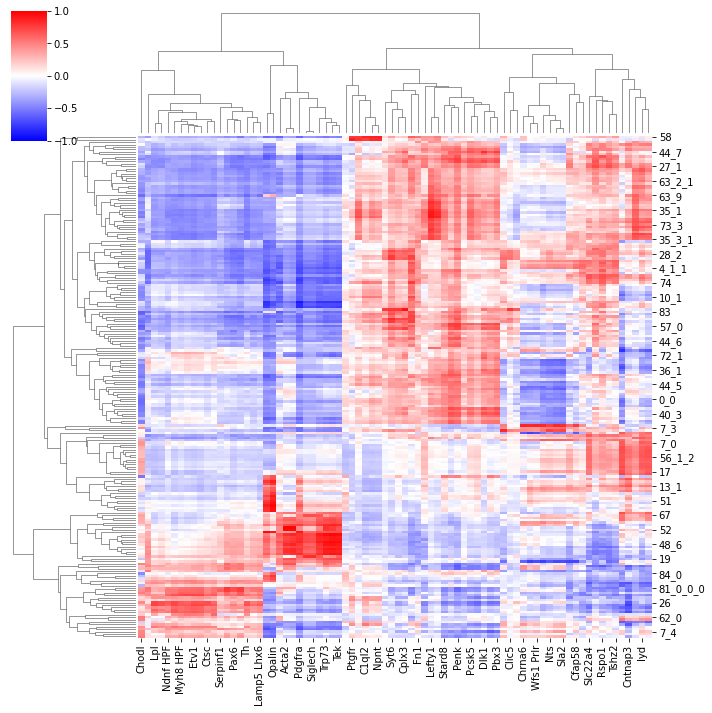

In [17]:
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_4_supertype_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =data_labels==i_label
    I = np.median(temp_data.layers['DPNMF_IQR'][i_mask,:],axis=0)
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        J = np.median(temp_ref_data.layers['DPNMF_IQR'][j_mask,:],axis=0)
        cmat[i,j] = pearsonr(I,J)[0]
# cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='bwr',vmin=-1,vmax=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [06:36<00:00,  1.92s/it]


<Figure size 1080x1080 with 0 Axes>

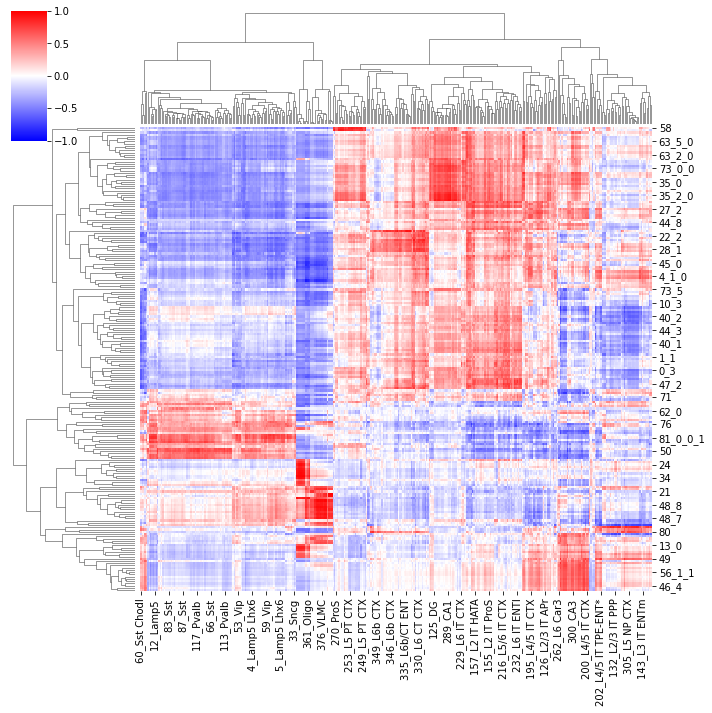

In [18]:
data_labels = np.array(temp_data.obs['opt_types'])
ref_data_labels = np.array(temp_ref_data.obsm['Level_5_cluster_label'])
data_labels_unique = np.unique(data_labels)
ref_data_labels_unique = np.unique(ref_data_labels)
cmat = np.zeros([data_labels_unique.shape[0],ref_data_labels_unique.shape[0]])
for i,i_label in tqdm(enumerate(data_labels_unique),total=data_labels_unique.shape[0]):
    i_mask =data_labels==i_label
    I = np.median(temp_data.layers['DPNMF_IQR'][i_mask,:],axis=0)
    for j,j_label in enumerate(ref_data_labels_unique):
        j_mask = ref_data_labels==j_label
        J = np.median(temp_ref_data.layers['DPNMF_IQR'][j_mask,:],axis=0)
        cmat[i,j] = pearsonr(I,J)[0]
# cmat = cmat/cmat.sum(0)[:,None].T
cmat = pd.DataFrame(cmat,index=data_labels_unique,columns=ref_data_labels_unique)
plt.figure(figsize=[15,15])
p = sns.clustermap(cmat,cmap='bwr',vmin=-1,vmax=1)